# Random Forest Regression

Fitting 1 folds for each of 5 candidates, totalling 5 fits
Best parameters for Decision Tree: {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 100, 'max_depth': None}


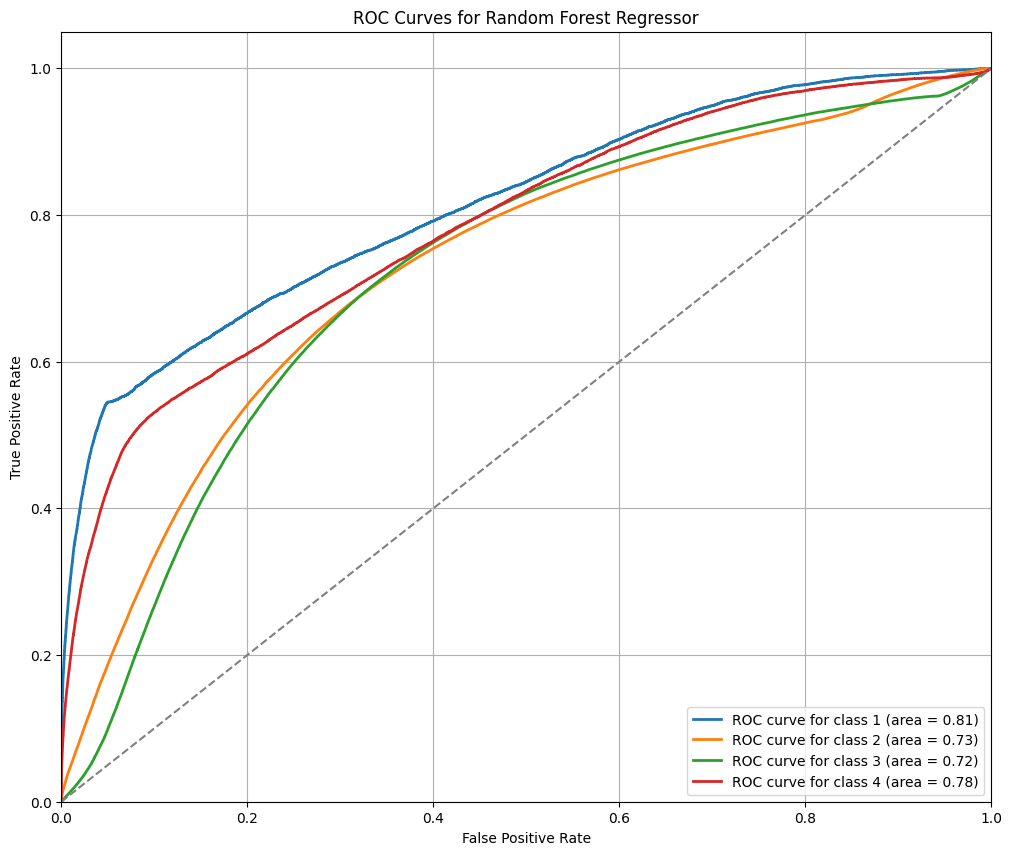

Random Forest Regression - MAE: 0.344591204875113
Random Forest Regression - MSE: 0.37080959617158316
Accuracy: 0.6684
R-squared (R²): -0.5855
Classification Report:
              precision    recall  f1-score   support

           1       0.31      0.22      0.26      9362
           2       0.89      0.69      0.78    873568
           3       0.31      0.67      0.43    188164
           4       0.37      0.17      0.23     27219

    accuracy                           0.67   1098313
   macro avg       0.47      0.44      0.42   1098313
weighted avg       0.78      0.67      0.70   1098313



In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

train_data = pd.read_csv("Train_Set.csv")
val_data = pd.read_csv("Validation_Set.csv")
test_data = pd.read_csv('Test_Set.csv')

X = train_data.drop(columns=["Severity"])
y = train_data["Severity"]

X_test = test_data.drop(columns=["Severity"])
y_test = test_data["Severity"]

combined_data = pd.concat([train_data, val_data], axis=0)
X_combined = combined_data.drop(columns=["Severity"])
y_combined = combined_data["Severity"]

# Create an indicator array for the validation set split
split_index = [-1] * len(train_data) + [0] * len(val_data)
predefined_split = PredefinedSplit(test_fold=split_index)

rf_param = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [100, 200, 500],
    'n_estimators': [10, 20],
    'max_depth': [None, 10]    
}

model_rf_cv = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions= rf_param,
    n_iter= 5,
    n_jobs=-1,
    scoring= 'neg_mean_squared_error',
    verbose=2,
    cv=predefined_split
)
model_rf_cv.fit(X_combined, y_combined)

# Get the best model from hyperparameter tuning
best_rf_model = model_rf_cv.best_estimator_
print("Best parameters for Decision Tree:", model_rf_cv.best_params_)

y_pred_rf = best_rf_model.predict(X_test)  
y_pred_rf_rounded = y_pred_rf.round().astype(int)

classes = sorted(y_test.unique())
n_classes = len(classes)

# Compute distances from each prediction to each class
distance_matrix = np.abs(y_pred_rf[:, np.newaxis] - np.array(classes))

# Convert distances to pseudo-probabilities using softmax
pseudo_prob_matrix = softmax(-distance_matrix, axis=1)

# Binarize the true labels for ROC curve
y_test_binarized = label_binarize(y_test, classes=classes)

# Plot ROC curves for each class
plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], pseudo_prob_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest Regressor')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf_rounded)
mse_rf = mean_squared_error(y_test, y_pred_rf_rounded)
accuracy = accuracy_score(y_test, y_pred_rf_rounded)
r2 = r2_score(y_test, y_pred_rf_rounded)
classification_report_str = classification_report(y_test, y_pred_rf_rounded)

print(f"Random Forest Regression - MAE: {mae_rf}")
print(f"Random Forest Regression - MSE: {mse_rf}")
print(f"Accuracy: {accuracy:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("Classification Report:")
print(classification_report_str)